# Q2 Main Notebook

In [95]:
# Import relevant libralies

import torch
import matplotlib.pyplot as plt
import math
import tqdm
from scipy.spatial.distance import hamming

# Determine the device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    )
print(f"The calculation was done using {device}")

The calculation was done using cuda


In [117]:
# Generate Training Samples
x = torch.linspace(-2, 2, 200).to(device)
y = torch.sin(math.pi * x /4).to(device)
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x, y),
    batch_size=1, # Size 1 for better generalization
    shuffle=True, # Shuffle to do SGD
    )

# Generate Test Samples
x_test = torch.linspace(-2, 2, 1000).view(-1,1).to(device)
y_test = torch.sin(math.pi * x_test /4).to(device)

# Define Training Specs
neural_nets = [torch.nn.Sequential(
    torch.nn.Linear(1, neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(neurons, 1)
).to(device) for neurons in range(2,4)]
optimizers = [torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.1) for net in neural_nets]
loss_func = torch.nn.MSELoss()
error_func = torch.nn.L1Loss(reduction='none')

losses_batch = []
losses_epoch_train = []
losses_epoch_test_avg = []
losses_epoch_test_max = []
hamming_dists = []

activation_patterns = []
pattern_start = []
pattern_end = []

last_test_max_loss = []

# Hook function to record the activation patterns for Q2, Q3
def hook_fn(module, input, output):
    boolean_array = (output>0).flatten().detach().cpu().numpy()
    activation_patterns.append(boolean_array)

# helper function tot turn a boolean pattern to str
def bool2str(boolean_array):
    pattern_str = ''.join(map(str,map(int,boolean_array)))
    return pattern_str

# function to clear patterns
def clear_activation_patterns():
    global activation_patterns
    activation_patterns = []

# register the hook to the ReLU layer
list(neural_nets[0].children())[1].register_forward_hook(hook_fn)
list(neural_nets[1].children())[1].register_forward_hook(hook_fn)
clear_activation_patterns()

# Train loop
for net, optimizer in zip(neural_nets, optimizers):
  losses_epoch_train = []
  losses_epoch_test_avg = []
  losses_epoch_test_max = []
  for epoch in tqdm.tqdm(range(300)):

    # find the activation pattern at the beginning
    clear_activation_patterns()
    for x_value in x:
      net(torch.tensor([x_value]).to(device))
    pattern_start = activation_patterns.copy()
    clear_activation_patterns()

    losses_batch = []
    for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            y_pred = net(x_batch)
            loss_value = loss_func(y_pred, y_batch)
            loss_value.backward()
            optimizer.step()
            losses_batch.append(loss_value.item())
    losses_epoch_train.append(sum(losses_batch) / len(losses_batch))
    losses_epoch_test_avg.append(error_func(net(x_test), y_test).mean().cpu().detach().numpy())
    losses_epoch_test_max.append(error_func(net(x_test), y_test).max().cpu().detach().numpy())

    # find the activation pattern at the end
    clear_activation_patterns()
    for x_value in x:
      net(torch.tensor([x_value]).to(device))
    pattern_end = activation_patterns.copy()
    clear_activation_patterns()
    # find the sum of the hamming distances
    hamming_dists.append(sum([hamming(pattern_start[i], pattern_end[i]) for i in range(len(pattern_start))]))

  last_test_max_loss.append(losses_epoch_test_max[-1])

100%|██████████| 300/300 [01:49<00:00,  2.74it/s]


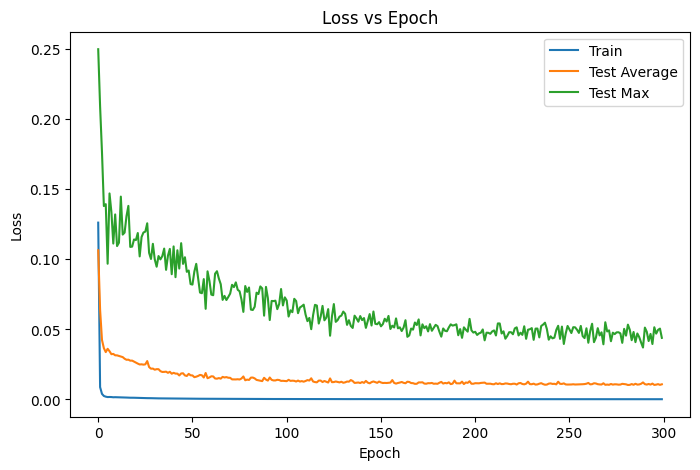

In [118]:
# Plot the loss and the test errors
plt.figure(figsize=(8, 5))
plt.plot(losses_epoch_train, label="Train")
plt.plot(losses_epoch_test_avg, label="Test Average")
plt.plot(losses_epoch_test_max, label="Test Max")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.savefig('q2a.png')
plt.show()

In [120]:
last_test_max_loss

[array(0.10111761, dtype=float32), array(0.04396987, dtype=float32)]

# Q2

In [128]:
activation_patterns = []
activation_regions = {}

# forward pass
for x_value in x_test:
    neural_nets[1](torch.tensor([x_value]).to(device))
    pattern_key = activation_patterns[-1]
    if pattern_key not in activation_regions:
        activation_regions[pattern_key] = [] # create an empty array to append
    activation_regions[pattern_key].append(x_value.item())

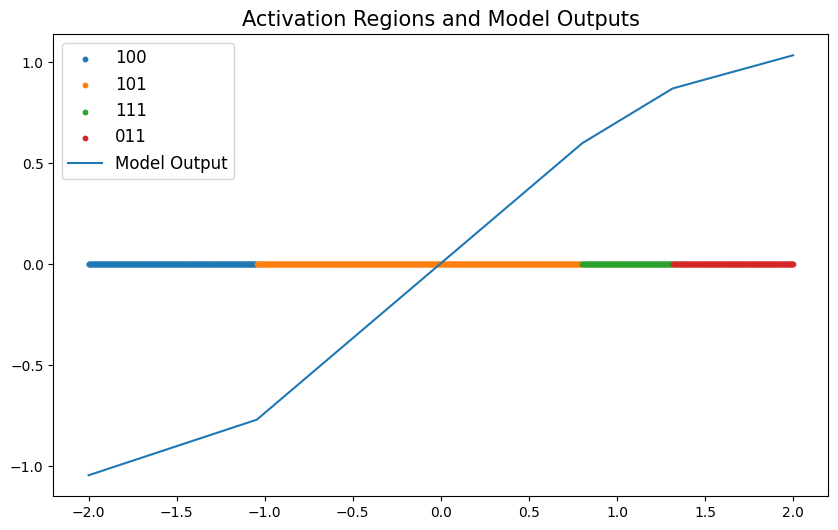

In [129]:
plt.figure(figsize=(10, 6))
for pattern, values in activation_regions.items():
    plt.scatter(values, [0] * len(values), label=bool2str(pattern), s=10)
plt.plot(x_test.cpu().detach().numpy(), neural_nets[1](x_test).cpu().detach().numpy(), label="Model Output")
plt.legend(fontsize=12)
plt.title("Activation Regions and Model Outputs", fontsize=15)
plt.savefig('q2b.png')
plt.show()

# Q3

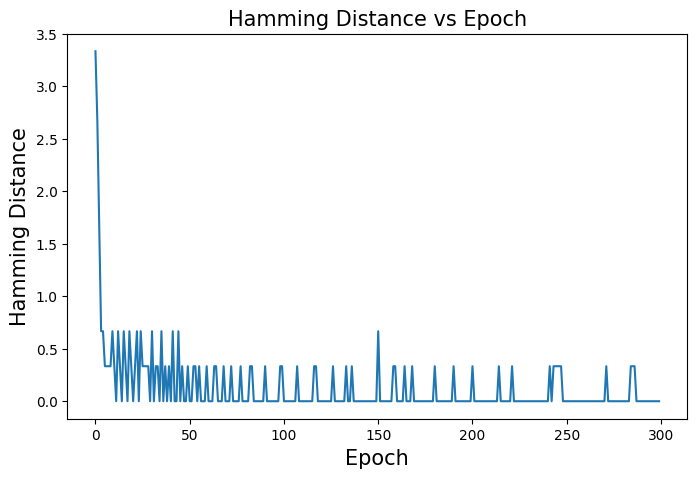

In [127]:
# plot the hamming distance
plt.figure(figsize=(8, 5))
plt.plot(hamming_dists[300:])
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Hamming Distance", fontsize=15)
plt.title("Hamming Distance vs Epoch",fontsize=15)
plt.savefig('q3.png')
plt.show()